In [1]:
from Assemblies.game import GameField
import numpy as np
import time
from numpy import random

%matplotlib inline
import matplotlib.pyplot as plt

<img src='1.4-1.8_title.png'></img>

# Asymptotic fraction of cooperators

## 1. Асимптотика плотности кооператоров для разных значений параметра выигрыша и фиксированного значения начального процента кооператоров

<img src='1.4-1.8_s1.png'></img>

- начальная плотность кооператоров 50% от общего числа активных игроков
- размер решётки 100x100
- 3000 шагов отжига и 500 шагов эволюции
- средние значения взяты по 500 шагам эволюции в 10 играх

In [2]:
eps=0.01
bs=np.array([8/5,9/5,2])+eps
L=100
cp=50

offp=np.linspace(80,0,num=20,dtype=int)

#в статье написано "100 samples", но пусть пока будет 10
seeds=np.zeros(10,dtype=int)
for i in range(10):
    seeds[i]=i+1

    
#информации по шагам отжига и эволюции я в статье не нашёл, поэтому пусть будет 3000 и 500 соответственно
burnin1=3000
evol1=500

In [3]:
#плотность для конкретного b
def c_density(size, coop_percentage, off_percentage, seed, burnin, evol, b): 
    random.seed(seed)
    instance = np.array(np.random.rand(size, size) <= 0.01 * off_percentage, dtype=int) * (-1)
    #здесь active означает места, занятые кооператорами или дефекторами
    active_indexes=(-1-instance).nonzero()
    active_size=active_indexes[0].size
    active = np.array(np.random.rand(active_size) > 0.01 * coop_percentage, dtype=int)
    instance[active_indexes]=np.copy(active)

    density = np.zeros(evol)
    
    game = GameField(size, b)
    game.field = np.copy(instance)
    game.evolveQ(burnin)
    for step in range(evol):
        game.evolveQ(1)
        density[step] = np.count_nonzero(np.equal(game.field,0)) / size**2
    return density

In [4]:
#измеряем плотность для len(seeds) разных реализаций на протяжении evol1 шагов. 
#Сначала усредняем по реализациям, потом эту величину - по шагам.

#функция возвращает массив плотности по значениям off_percentage для определённого процента кооператоров и определённого b
def total_density(size, coop_percentage, off_percentage, seeds, burnin, evol, b):
    
    aver_all=np.zeros(len(off_percentage))
    for i in range(len(off_percentage)):
        den=np.zeros((len(seeds),evol))

        for j in range(len(seeds)):
            den[j]=c_density(size, coop_percentage, off_percentage[i], seeds[j], burnin, evol, b)

        aver_seed=np.mean(den,axis=0)
        aver_all[i]=np.mean(aver_seed)

    return aver_all 

In [5]:
ds=np.zeros((len(bs),len(offp)))
for i in range(len(bs)):
    ds[i]=total_density(size=L, coop_percentage=cp, off_percentage=offp, seeds=seeds, burnin=burnin1, evol=evol1, b=bs[i])

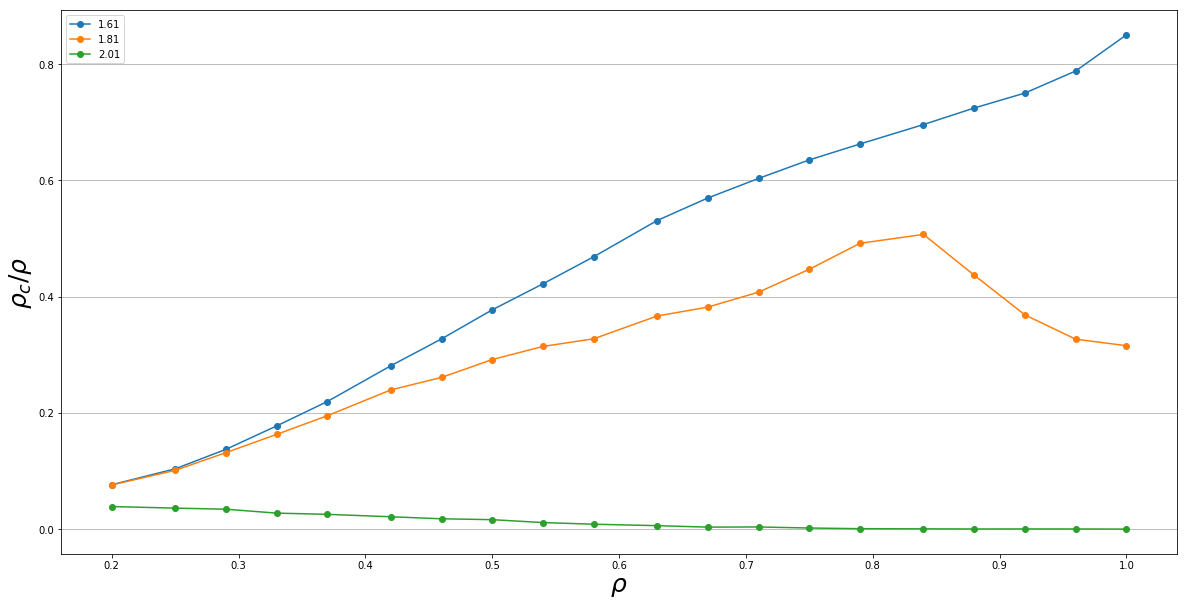

In [6]:
fig,ax=plt.subplots(1,1,figsize=(20,10))
ax.grid(b=True,axis='y')
for i in range(len(ds)):
    ax.plot(1-offp*0.01,ds[i],'o-',label=bs[i])

ax.set_xlabel('$%s$'%'\\rho',fontsize=25)
ax.set_ylabel('$%s$'%'\\rho_c/\\rho',fontsize=25)
ax.legend()    

In [7]:
maxind=np.argmax(ds[1])
p_star=(100-offp)[maxind]
print('критический процент заполненности решётки p* = ', p_star)

критический процент заполненности решётки p* =  84


## 2. Асимптотика плотности кооператоров для фиксированного значения параметра выигрыша и разных значений начального процента кооператоров

<img src='1.4-1.8_s2.png'></img>

In [8]:
cps=np.array([33,50,66,90])

ds2=np.zeros((len(cps),len(offp)))
for i in range(len(cps)):
    ds2[i]=total_density(size=L, coop_percentage=cps[i], off_percentage=offp, seeds=seeds, burnin=burnin1, evol=evol1, b=bs[1])

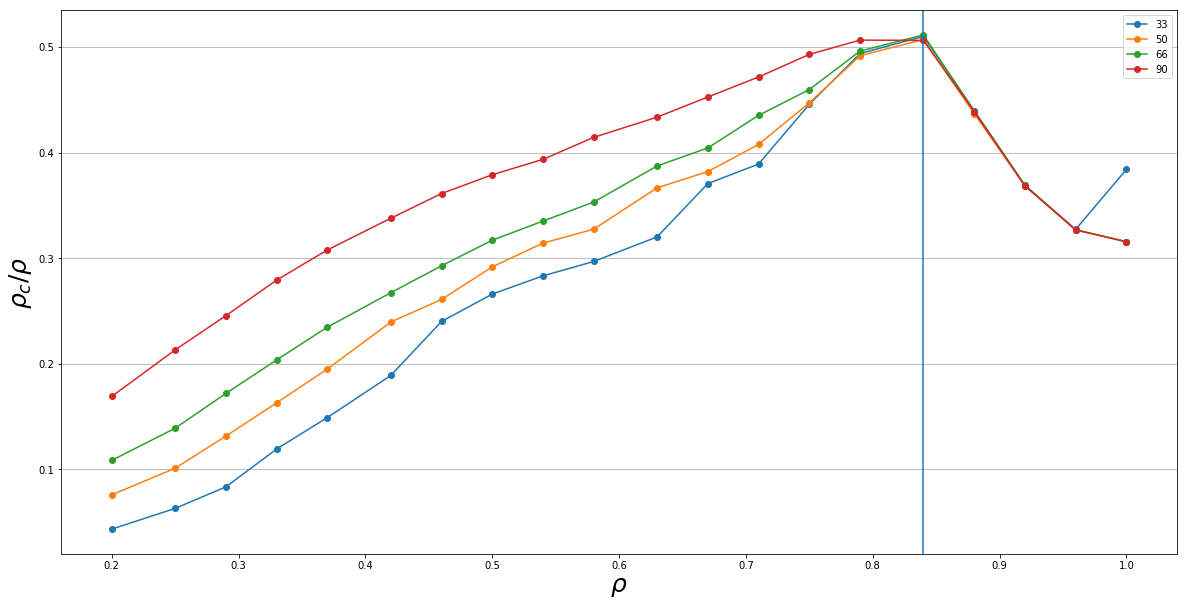

In [9]:
fig,ax=plt.subplots(1,1,figsize=(20,10))
ax.grid(b=True,axis='y')
for i in range(len(ds2)):
    ax.plot(1-offp*0.01,ds2[i],'o-',label=cps[i])

ax.axvline(x=.01*p_star)    
ax.set_xlabel('$%s$'%'\\rho',fontsize=25)
ax.set_ylabel('$%s$'%'\\rho_c/\\rho',fontsize=25)
ax.legend()    

# Persistence
## 3. Неизменность стратегий игроков для процента заполненности решётки, ниже $p^*$

<img src='1.4-1.8_per.png'></img>
<img src='1.4-1.8_s3.png'></img>

In [6]:
#массив значений persistence на протяжении t-tw шагов для определённой реализации игры
def persistence(size, coop_percentage, off_percentage, seed, b, t, tw):
    random.seed(seed)
    instance = np.array(np.random.rand(size, size) <= 0.01 * off_percentage, dtype=int) * (-1)
    active_indexes=(-1-instance).nonzero()
    active_size=active_indexes[0].size
    active = np.array(np.random.rand(active_size) > 0.01 * coop_percentage, dtype=int)
    instance[active_indexes]=np.copy(active)
    
    c=active_size
    persistence=np.zeros(t-tw)
    
    #флаги индексы элементов
    #0 - прошёл проверку на неизменность стратегий, 1 - не прошёл
    dropout_flags=np.zeros(active_size, dtype=int) 
    
    game = GameField(size, b)
    game.field = np.copy(instance)
    game.evolveQ(tw)
    for step in range(t-tw):
        game.evolveQ(1)
        
        evolution=np.copy(game.field[active_indexes])
        
        for i in range(len(evolution)):
            if (dropout_flags[i]!=1) and (evolution[i]!=active[i]):
                c-=1
                dropout_flags[i]=1
        
        persistence[step]=c/active_size
    return persistence

In [11]:
points1=np.linspace(p_star, 70, num=5, dtype=int)
t1=1000
tw1=0

In [10]:
pers1=np.zeros((len(points1), t1-tw1))
for i in range(len(points1)):
    pers1[i]=persistence(size=100,coop_percentage=50,off_percentage=100-points1[i],seed=1,b=bs[1],t=t1,tw=tw1)

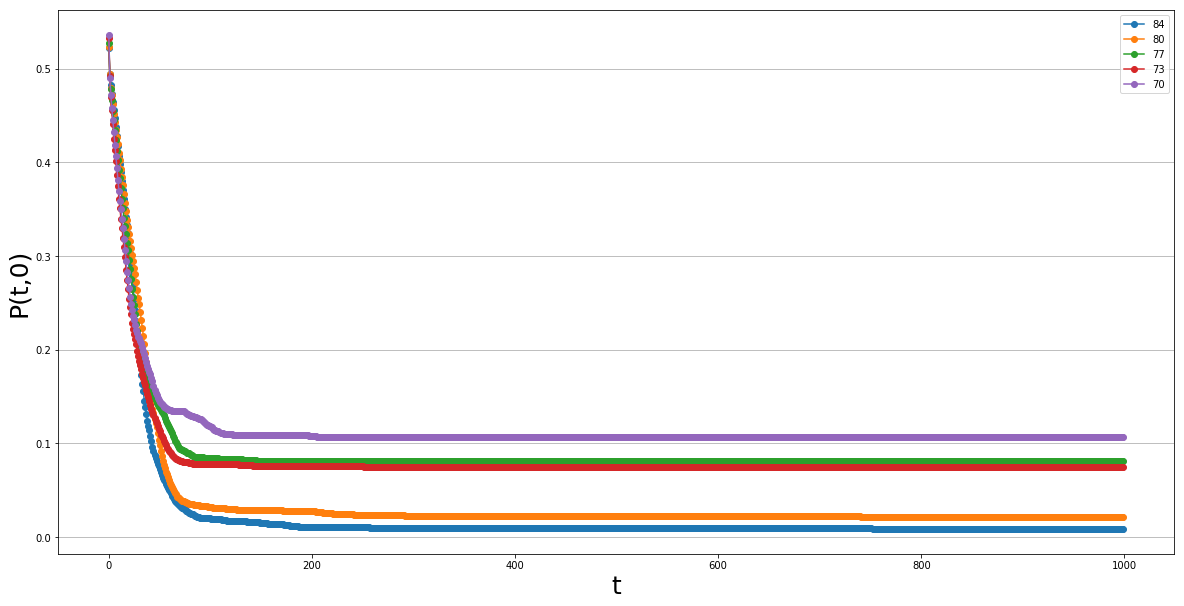

In [11]:
fig,ax=plt.subplots(1,1,figsize=(20,10))
ax.grid(b=True,axis='y')
for i in range(len(pers1)):
    ax.plot(pers1[i],'o-',label=points1[i])
    
ax.set_xlabel('t',fontsize=25)
ax.set_ylabel('P(t,0)',fontsize=25)
ax.legend()  

## 3.1. Высота плато неизменности в зависимости от процента заполненности решётки

In [12]:
points31=np.linspace(90,0,num=50,dtype=int)

In [13]:
pers31=np.zeros((len(points31), 1))
for i in range(len(points31)):
    pers31[i]=persistence(size=100,coop_percentage=50,off_percentage=points31[i],seed=1,b=bs[1],t=t1,tw=tw1)[-1]

Text(0,0.5,'$P(\\infty,0)$')

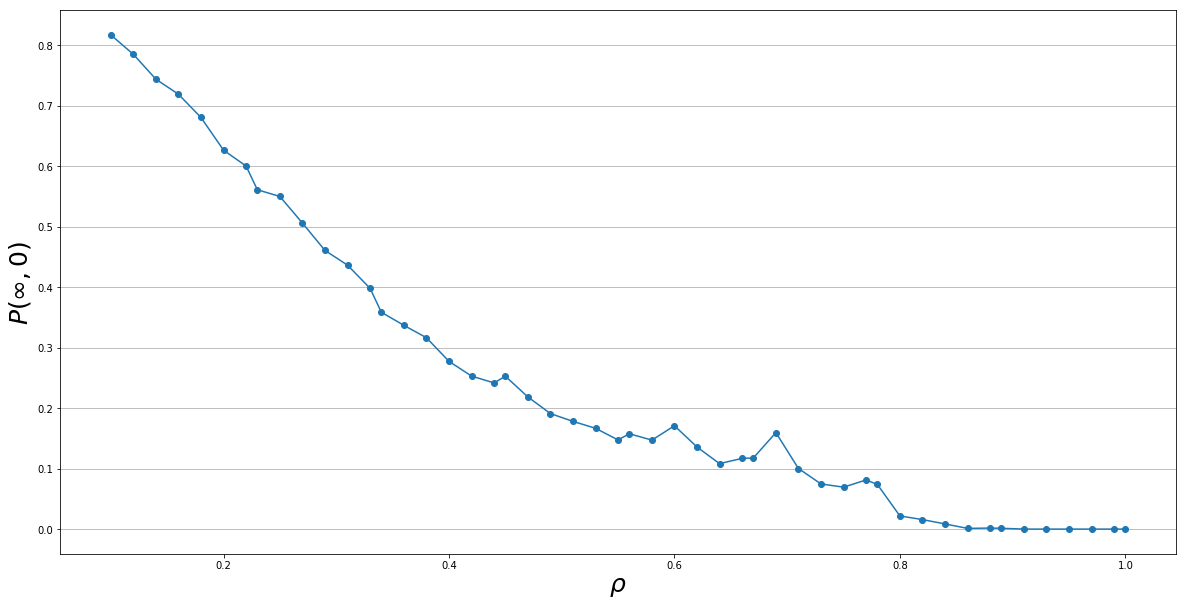

In [14]:
fig,ax=plt.subplots(1,1,figsize=(20,10))
ax.grid(b=True,axis='y')

ax.plot(1-0.01*points31, pers31,'o-')
    
ax.set_xlabel('$%s$'%'\\rho',fontsize=25)
ax.set_ylabel('$%s$'%'P(\\infty,0)',fontsize=25)

Рассмотрим поближе высоту плато вблизи точки $\rho*$

In [15]:
points_close=np.linspace(78, p_star, num=100)

In [16]:
pers_close=np.zeros((len(points_close), 1))
for i in range(len(points_close)):
    pers_close[i]=persistence(size=100,coop_percentage=50,off_percentage=100-points_close[i],seed=1,b=bs[1],t=t1,tw=tw1)[-1]

Text(0,0.5,'$P(\\infty,0)$')

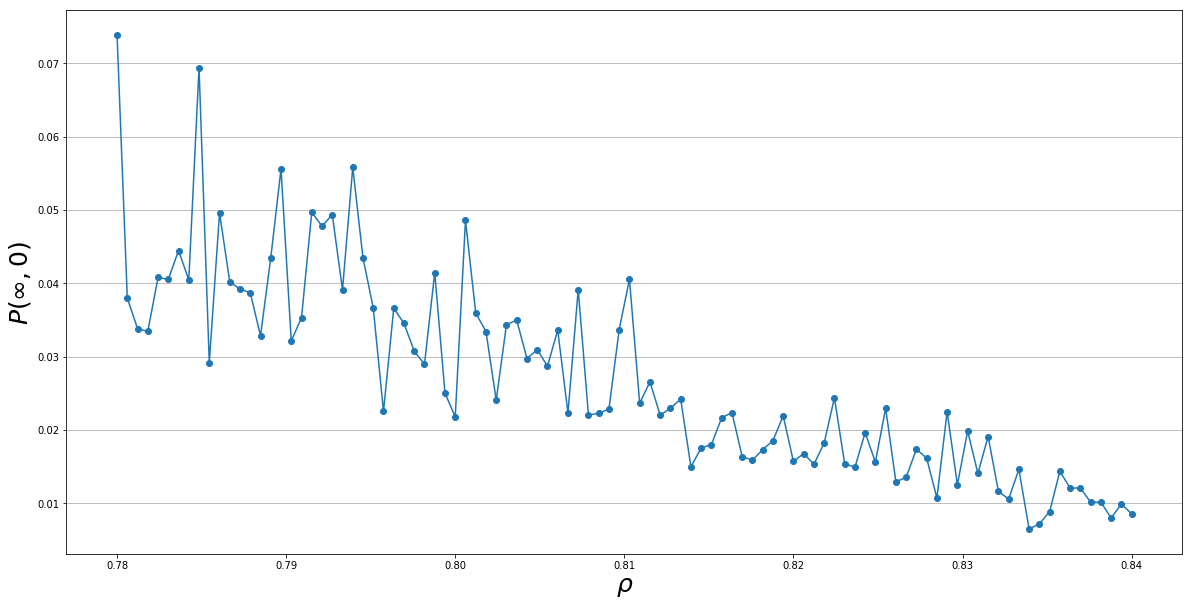

In [17]:
fig,ax=plt.subplots(1,1,figsize=(20,10))
ax.grid(b=True,axis='y')

ax.plot(0.01*points_close, pers_close,'o-')
    
ax.set_xlabel('$%s$'%'\\rho',fontsize=25)
ax.set_ylabel('$%s$'%'P(\\infty,0)',fontsize=25)

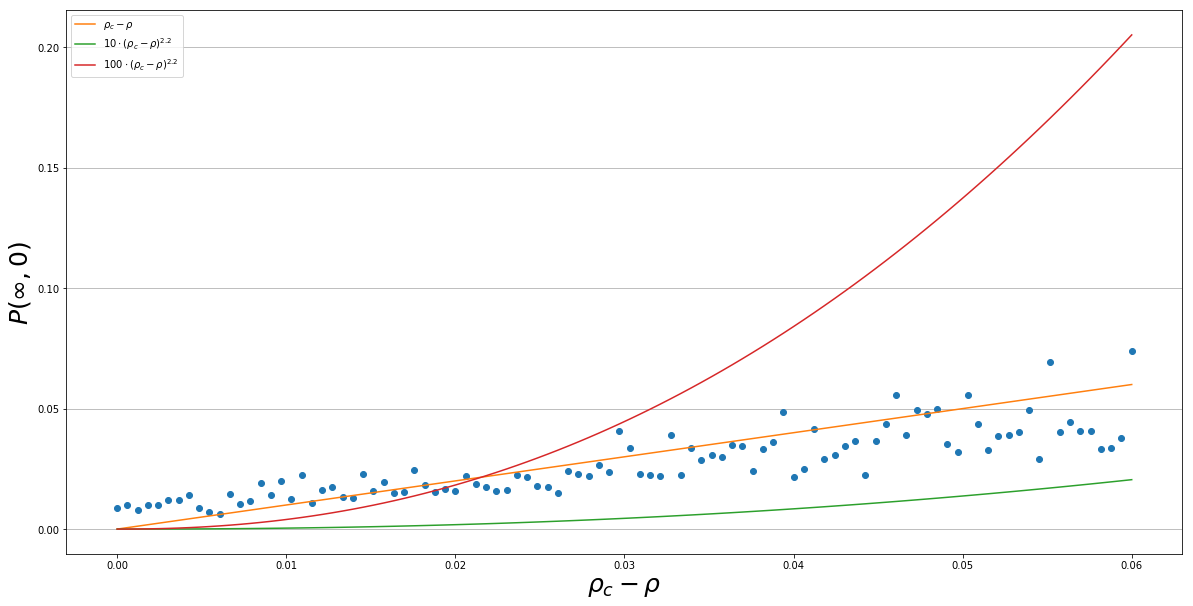

In [21]:
fig,ax=plt.subplots(1,1,figsize=(20,10))
ax.grid(b=True,axis='y')

ax.plot(0.01*(p_star-points_close[::-1]), pers_close[::-1],'o')
ax.plot(0.01*(p_star-points_close[::-1]),(0.01*(p_star-points_close[::-1]))**1, label='$%s$'%'\\rho_c-\\rho')
ax.plot(0.01*(p_star-points_close[::-1]),10*(0.01*(p_star-points_close[::-1]))**2.2, label='$%s$'%'10\cdot(\\rho_c-\\rho)^{2.2}')
ax.plot(0.01*(p_star-points_close[::-1]),100*(0.01*(p_star-points_close[::-1]))**2.2, label='$%s$'%'100\cdot(\\rho_c-\\rho)^{2.2}')
    
ax.set_xlabel('$%s$'%'\\rho_c-\\rho',fontsize=25)
ax.set_ylabel('$%s$'%'P(\\infty,0)',fontsize=25)
ax.legend()

## 4. Неизменность стратегий игроков для процента заполненности решётки, выше $p^*$

<img src='1.4-1.8_s4.png'></img>

In [14]:
points2=np.linspace(p_star, 100, num=5, dtype=int)
t1=1000
tw1=0

In [15]:
pers2=np.zeros((len(points2), t1-tw1))
for i in range(len(points2)):
    pers2[i]=persistence(size=100,coop_percentage=50,off_percentage=100-points2[i],seed=1,b=bs[1],t=t1,tw=tw1)

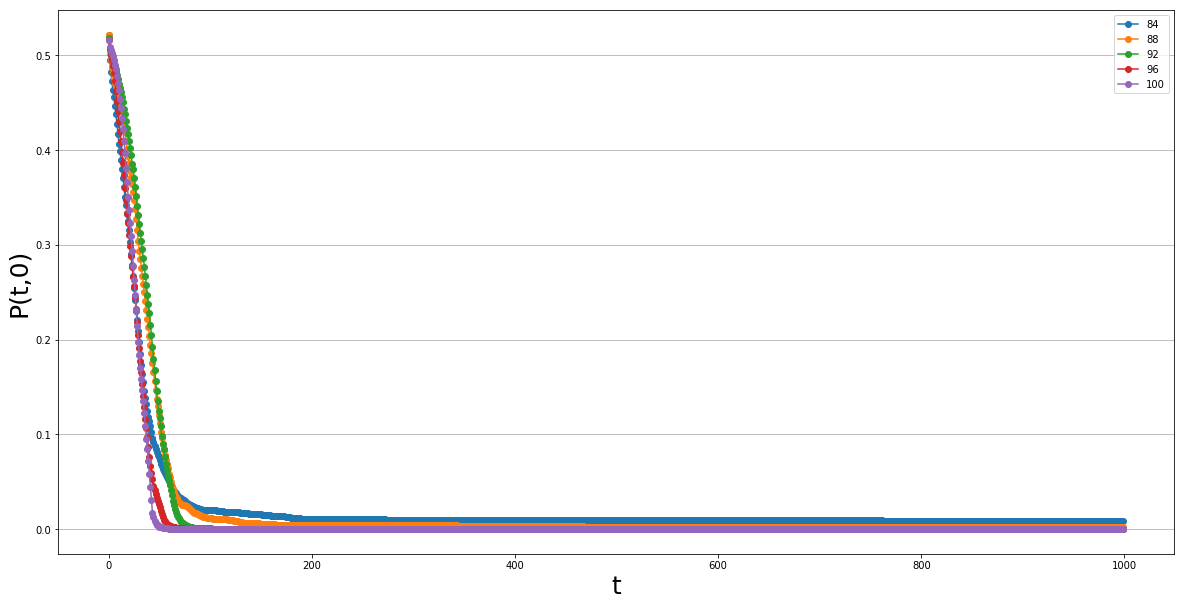

In [16]:
fig,ax=plt.subplots(1,1,figsize=(20,10))
ax.grid(b=True,axis='y')
for i in range(len(pers2)):
    ax.plot(pers2[i],'o-',label=points2[i])
    
ax.set_xlabel('t',fontsize=25)
ax.set_ylabel('P(t,0)',fontsize=25)
ax.legend()  